<a href="https://colab.research.google.com/github/JayThibs/Weak-Supervised-Learning-Case-Study/blob/main/text_classifier/notebooks/05_toxicity_classification_snorkel_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Binary Classification Dataset of the Toxicity Dataset with Snorkel

In order to simplify the problem, we are going to turn this multi-label classification problem (does it contain any of these 'bad' labels?) to a binary classification problem (is it a 'bad' comment or not?).

We've already trained a multi-label model for this problem in notebook 01, so why are we doing this? We are doing this for a few reasons:

1. We want to test how well we can create labeling functions with Snorkel to build a dataset without knowing the labels.

2. It takes time to create many labeling functions that create a useful dataset, and it takes longer if it's for a multi-class classification problem, and even longer for multi-label classification. Therefore, in the interest of time, we will make the classification binary.

3. We want to try implementing Active Learning into our prototype and it will be simpler to start with a binary classification model.


Some of the code is borrowed from:

1. https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing#scrollTo=acF4YRlQL8iz

2. https://www.inovex.de/blog/snorkel-weak-superversion-german-texts/

3. https://trishalaneeraj.github.io/2020-07-26/data-labeling-weak-supervision

In [1]:
!pip install snorkel --quiet
!pip install datasets --quiet
!pip install spacy --quiet
!pip install pip install better-profanity --quiet
!pip install pytorch-lightning==1.2.8 --quiet
!pip install transformers==4.5.1 --quiet
!pip install wandb --quiet
# !python -m spacy download en_core_web_md --quiet

     |████████████████████████████████| 153kB 9.2MB/s 
     |████████████████████████████████| 1.8MB 13.6MB/s 
     |████████████████████████████████| 3.8MB 49.2MB/s 
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 225kB 8.0MB/s 
     |████████████████████████████████| 245kB 49.2MB/s 
     |████████████████████████████████| 112kB 49.3MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 849kB 8.8MB/s 
     |████████████████████████████████| 829kB 53.2MB/s 
     |████████████████████████████████| 276kB 56.8MB/s 
     |████████████████████████████████| 6.0MB 50.5MB/s 
     |████████████████████████████████| 276kB 51.9MB/s 
     |████████████████████████████████| 1.3MB 45.7MB/s 
     |████████████████████████████████| 4.

In [87]:
import pandas as pd
from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.labeling.lf.nlp import nlp_labeling_function
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from better_profanity import profanity
from snorkel.labeling import PandasLFApplier
from sklearn.model_selection import train_test_split
import spacy
from spacy.matcher import Matcher
import numpy as np
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import PhraseMatcher

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSequenceClassification

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, BackboneFinetuning, QuantizationAwareTraining
from pytorch_lightning.loggers import TensorBoardLogger
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

# weights and biases
import wandb

# lightning plus wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

Global seed set to 42


True

## Data

Our dataset contains potentially offensive (toxic) comments and comes from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Let's start by download the data (from Google Drive):

In [3]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
68.8MB [00:01, 59.0MB/s]


We can take a look at the data:

In [4]:
# we can see 
df = pd.read_csv("toxic_comments.csv")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


As we can see, we have comments from YouTube videos where most are clean comments, but there are some bad comments that are labeled as either: toxic,	severe_toxic,	obscene,	threat,	insult and/or	identity_hate. We will bunch them all together into the same label we will call 'labels' because Snorkel prefers this.

## Preprocessing

Let's have a look at the dataset before we start creating labeling functions.

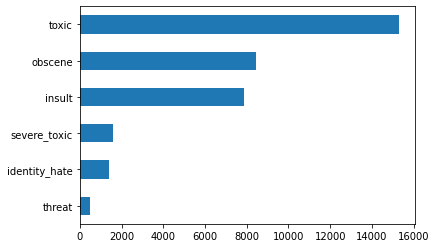

In [5]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

Now, let's add them all up together and compare them to the number of clean comments.

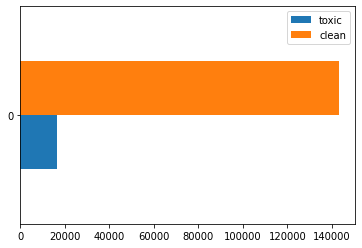

In [6]:
df_toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
df_clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(df_toxic)], 
  clean=[len(df_clean)]
)).plot(kind='barh');

The bad examples are imbalanced, but we will not worry about that. What we will do, however, is to eliminate clean examples from the dataset in order to make it more balanced. We will simply reduce the number of clean comments to a number that is comparable to the toxic comments.

In [7]:
train_df = pd.concat([
  df_toxic.sample(1500, random_state=42),
  df_clean.sample(1500, random_state=42)
])

print(len(train_df))
train_df.head()

3000


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check ...",1,0,0,0,0,0
27198,47f18388952e3ee7,White Trash\nFuck off you white piece of trash...,1,1,1,0,1,1
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1,0,1,0,1,0
8158,15b6fd032e614001,DUMB ASSES\nIt's was my sockpuppet...joe hazet...,1,0,0,0,0,0
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-c...",1,0,1,0,1,0


### Merging All Toxic Comments Together

In [8]:
train_df['label'] = np.where(train_df[LABEL_COLUMNS].sum(axis=1) == 0, 0, 1)
train_df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
88045,eb8cefa54813f3bc,Thanks and bye\nJust wanted to thank you for m...,0,0,0,0,0,0,0
44474,76c473f8898626ce,"Seems to be at it again, in force",0,0,0,0,0,0,0
75044,c8cc3dca0745ba2f,Still meaningless. It's a random example of Wi...,0,0,0,0,0,0,0
103363,29236fd9f0ccd41e,I don't know. Is it a good idea to delete art...,0,0,0,0,0,0,0
130762,bb846cf699d149a4,"""\n\nActually, the NY Times made much the same...",0,0,0,0,0,0,0


In [9]:
train_df = train_df.drop(LABEL_COLUMNS, axis=1)
train_df

,id,comment_text,label
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check ...",1
27198,47f18388952e3ee7,White Trash\nFuck off you white piece of trash...,1
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1
8158,15b6fd032e614001,DUMB ASSES\nIt's was my sockpuppet...joe hazet...,1
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-c...",1
...,...,...,...
88045,eb8cefa54813f3bc,Thanks and bye\nJust wanted to thank you for m...,0
44474,76c473f8898626ce,"Seems to be at it again, in force",0
75044,c8cc3dca0745ba2f,Still meaningless. It's a random example of Wi...,0
103363,29236fd9f0ccd41e,I don't know. Is it a good idea to delete art...,0


## Preparing the Data for Snorkel

In [10]:
train_df = train_df.rename(columns={"comment_text": "text"})
train_df.head()

,id,text,label
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check ...",1
27198,47f18388952e3ee7,White Trash\nFuck off you white piece of trash...,1
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1
8158,15b6fd032e614001,DUMB ASSES\nIt's was my sockpuppet...joe hazet...,1
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-c...",1


In [11]:
dev_df = train_df.groupby('label').apply(lambda s: s.sample(100, random_state=123)).reset_index(level=0, drop=True)
train_df.drop(dev_df.index, inplace=True)

train_df, test_df = train_test_split(train_df, test_size=0.25)
val_df = test_df.sample(frac=0.1)
test_df.drop(val_df.index, inplace=True)

print('Train:', len(train_df), '\t Dev:', len(dev_df), '\t Test:', len(test_df), '\t', 'Valid:', len(val_df))

Train: 2100 	 Dev: 200 	 Test: 630 	 Valid: 70


In [12]:
train_df.to_csv('toxic_train_2100_examples.csv')
test_df.to_csv('toxic_test_630_examples.csv')
val_df.to_csv('toxic_val_70_examples.csv')
dev_df.to_csv('toxic_dev_200_examples.csv')

In [13]:
train_df.drop(['label'], axis=1, inplace=True)

## Writing Labeling Functions (LFs)

For clarity, we define constants to represent the class labels for non-toxic, toxic, and abstaining. These will go into our labeling functions so that the constants feed into the labeling process.

In [14]:
ABSTAIN = -1
NONTOXIC = 0
TOXIC = 1

In [15]:
# Useful for looking at the data and creating the labeling functions
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

Let's at a sample of the dataset so that we can come up with labeling functions.

In [16]:
dev_df

,id,text,label
75562,ca209ba9f5e6c427,"""\n\nQuoting it in full:\n\n A7. No indication of importance (individuals, animals, organizations, web content).\n An article about a real person, individual animal(s), organization (e.g. band, club, company, etc., except schools),Past discussions leading to schools being exempt from A7. or web content that does not indicate why its subject is important or significant. This is distinct from verifiability and reliability of sources, and is a lower standard than notability. This criterion applies only to articles about web content and to articles about people, organizations, and individual animals themselves, not to articles about their books, albums, software, or other creative works. This criterion does not apply to species of animals, only to individual animal(s). The criterion does not apply to any article that makes any credible claim of significance or importance even if the claim is not supported by a reliable source or does not qualify on Wikipedia's notability guidelines.It is irrelevant whether the claim of notability within the article falls below the notability guidelines. If the claim is credible, the A7 tag can not be applied. The criterion does apply if the claim of significance or importance given is not credible. If the claim's credibility is unclear, you can improve the article yourself, propose deletion, or list the article at articles for deletion.\n , – for people, – for bands, – for clubs, societies, groups, and organizations, – for companies and corporations, – for websites, – for individual animals\n\nPlease note the bolded text.""",0
132186,c35ee1f2038ebd08,"File:Hurricane-Katrina-Grand-Casino-Gulfport-hotel-EPA.jpg\nHi. If you'd be able to track down the source description page and info for File:Hurricane-Katrina-Grand-Casino-Gulfport-hotel-EPA.jpg which you uploaded here a while back and is now on Commons, that would be great, thanks! Thanks for your work. Cheers,",0
3704,09e68df5ff03c01f,"message from you regarding THREATS, STALKING, HARASSMENT, VIOLATION OF TERMS OF SERVICE AND CYBER BULLING FROM USER KERI.\n\nUser Keri has engaged in a pattern of threat, harassment, stalking and cyberbullying against me despite my telling them never to contact me again.\nNext I got an implicit threat from you alleging a legal threat involving me. The conduct that user KERI is involved in are all illegal and I have repeatedly demanded that user stop contacting me. Stop using your position of authority to takes sides with the mods and admins against the 99% by censoring us and trying to intimidate us.",0
42542,718a3018dc34e106,"I'll give you the benefit of the doubt as an experienced editor; however, in my personal opinion, we do not need a redirect to every article title from every conceivable grammatical variant of the title which might theoretically be used in a sentence. That's what piped links are for. (call me Russ)",0
110576,4f8eeca4ccf6d666,"Communists Appearing on Iranian TV + Are They Having A Laugh? \n\nThat is the question. History students will know that Communists inspired the Iranian Revolution in 1979 and did the heavy lifting. They were then butchered by the Ayatollah and his followers. So, what kind of a Leftie would make an appearance on Press TV, which is run by the same Govt? Some kind of a Useful Idiot, that's who!",0
40861,6d0ed912c0293979,I'll revise the criticism when A520 does. The unprofessional behaviour of this user indicates he ought not to have admin privileges. He has been reported for abuse of authority.,0
39876,6a7407a8b3b92b58,"""\n\n Dan56 is bullying contributors \n\nWhy are you guys allowing this one guy to control the page? He will not allow anything true to be put, only his own opinion. Metacritic gives the album a 76. That means """"generally positive."""" That's a very nice review. Why does Dan56 keep removing that when I add it? His opinion should not count more than the 14 critics cited. Please help with fairness. I understand he loves

In [17]:
# Showing the most common words to make the labeling function creation process quicker
# This is where we can come up with a custom keyword list

pd.Series(' '.join(dev_df[dev_df['label'] == 1].sample(100, random_state=42).text).split()).value_counts()[:100]

YOURSELF        149
DRINK           149
KILL            149
BLEACHANHERO    148
you             112
the              92
and              87
to               86
I                84
a                83
of               54
your             47
is               44
are              36
my               36
that             34
on               29
for              28
in               28
be               25
have             24
it               24
not              22
with             22
You              19
"                18
don't            17
an               17
me               17
this             17
like             16
they             15
but              15
he               15
as               15
was              15
fucking          14
all              14
do               13
about            12
or               12
Wikipedia        12
who              12
will             11
at               11
know             11
what             11
so               11
from             10
i                10


### Labeling Functions

In [18]:
@nlp_labeling_function()
def contains_work_of_art(x):
    """If comment contains titles of books, songs, etc., label non-toxic, else abstain"""
    if any([ent.label_ == "WORK_OF_ART" for ent in x.doc.ents]):
        return NONTOXIC
    else:
        return ABSTAIN
    
@nlp_labeling_function()
def contains_entity(x):
    """If comment contains least 3 mentions of an entity, label non-toxic, else abstain"""
    if len([ent.label_ in ["PERSON", "GPE", "LOC", "ORG", "LAW", "LANGUAGE"] for ent in x.doc.ents])>2:
        return NONTOXIC
    else:
        return ABSTAIN

In [19]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    """If comment has a polarity score between +0.9 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    """If comment has a subjectivity score between +0.7 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.subjectivity >= 0.7 else ABSTAIN

In [20]:
# @labeling_function()
# def contains_profanity(x):
#     """
#     If comment contains profanity label toxic, else abstain. 
#     Profanity determined using this library - https://github.com/snguyenthanh/better_profanity
#     """
#     return TOXIC if profanity.contains_profanity(x.text) else ABSTAIN

In [21]:
# @nlp_labeling_function()
# def contains_pleaseread(x):
#     """
#     Will match commonly occuring phrases like - 
#     Please read this
#     Please read the
#     Please read
#     """
#     matcher = PhraseMatcher(nlp.vocab)
#     pattern = [{"LEMMA": "please"},
#                {"LEMMA": "read"},
#                {"LEMMA": "the", "OP": "?"},
#                {"LEMMA": "this", "OP": "?"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

@nlp_labeling_function()
def contains_stopvandalizing(x):
    """
    Will match commonly occuring phrases like - 
    stop vandalizing
    do not vandalize
    don't vandalize
    """
    matcher = Matcher(nlp.vocab)
    pattern1 = [{"LEMMA": "do"},
                {"LEMMA": "not"},
                {"LEMMA": "vandalize"}]
    pattern2 = [{"LEMMA": "stop"}, 
                {"LEMMA": "vandalize"}]
    matcher.add("p1", None, pattern1)
    matcher.add("p2", None, pattern2)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
# @nlp_labeling_function()
# def contains_harassme(x):
#     """
#     Will match commonly occuring phrases like - 
#     harass me
#     harassed me
#     harassing me
#     """
#     matcher = Matcher(nlp.vocab)
#     pattern = [{"LOWER": "harass"}, 
#                {"LOWER": "me"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

# @nlp_labeling_function()
# def contains_willreport(x):
#     """Will match commonly observed phrases like - 
#     report you
#     reported you
#     reporting you
#     reported your
#     """
#     matcher = Matcher(nlp.vocab)
#     pattern = [{"LEMMA": "report"}, 
#                {"LEMMA": "you"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

In [22]:
@nlp_labeling_function()
def contains_email(x):
    """If comment contains email address, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_EMAIL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
@nlp_labeling_function()
def contains_url(x):
    """If comment contains url, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_URL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN

In [23]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=TOXIC):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

# with open('badwords.txt') as f:
#     toxic_stopwords = f.readlines()

# toxic_stopwords = [x.strip() for x in toxic_stopwords] # len = 458
# """Comments mentioning at least one of Google's Toxic Stopwords 
# https://code.google.com/archive/p/badwordslist/downloads are likely toxic"""
# keyword_toxic_stopwords = make_keyword_lf(keywords=toxic_stopwords)

keyword_please = make_keyword_lf(keywords=["please", "plz", "pls", "pl", "Please read this", "Please read the", "Please read"], label=NONTOXIC)

keyword_thanks = make_keyword_lf(keywords=["thanks", "thank you", "thx", "tx"], label=NONTOXIC)

In [24]:
# @labeling_function()
# def capslock(x):
#     """If comment is written in all caps, label toxic, else abstain"""
#     return TOXIC if x.text == x.text.upper() else ABSTAIN

#### Creating BERT sentiment model for labeling

In [25]:
BERT_MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

In [26]:
model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [27]:
MAX_TOKEN_COUNT = 512

In [28]:
sample_comment = "The problem with saying that Warren G. Harding was the first African-American President is that it"

In [29]:
data_row = dev_df.iloc[19]

sample_text = data_row.text
labels = data_row['label']

print(sample_text)
print()
print(labels)

Important people of the battle 

Brack Obama
Santa Clause
Easter Bunny
Leprechaun
Ron Gerardis
Cupid
Ronald Mcdonald
Tooth Fairy

0


In [30]:
encoding = tokenizer.encode_plus(
  sample_text,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [31]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'important', 'people', 'of', 'the', 'battle', 'bra', '##ck', 'obama', 'santa', 'clause', 'easter', 'bunny', 'le', '##pre', '##chau', '##n', 'ron', 'gerard', '##is']


In [32]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [33]:
torch.cuda.empty_cache()

In [34]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.text
    labels = data_row['label']

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=labels
    )

In [35]:
train_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [36]:
sample_item["comment_text"]

"Bone to pick \n\nWhat makes you the rulemaker on all things bears related?  Bad and Good go into articles.  Get a life and stay off wikipedia for a good month or two.  People like you are the reason that wikipedia is a joke.  Too much of your personal feelings goes into making sure nothing you don't agree with gets put into an article.  Last I checked your job wasn't encyclopedia writer, so let others ideas be put into articles.214.13.192.187"

In [37]:
sample_item["labels"]

0

In [38]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [39]:
output = model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [40]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

In [41]:
model.config.hidden_size

768

In [42]:
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=4, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=4
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=4
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=4
    )

In [43]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = ToxicCommentDataModule(
  dev_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [44]:
dev_df.head()

,id,text,label
75562,ca209ba9f5e6c427,"""\n\nQuoting it in full:\n\n A7. No indication of importance (individuals, animals, organizations, web content).\n An article about a real person, individual animal(s), organization (e.g. band, club, company, etc., except schools),Past discussions leading to schools being exempt from A7. or web content that does not indicate why its subject is important or significant. This is distinct from verifiability and reliability of sources, and is a lower standard than notability. This criterion applies only to articles about web content and to articles about people, organizations, and individual animals themselves, not to articles about their books, albums, software, or other creative works. This criterion does not apply to species of animals, only to individual animal(s). The criterion does not apply to any article that makes any credible claim of significance or importance even if the claim is not supported by a reliable source or does not qualify on Wikipedia's notability guidelines.It is irrelevant whether the claim of notability within the article falls below the notability guidelines. If the claim is credible, the A7 tag can not be applied. The criterion does apply if the claim of significance or importance given is not credible. If the claim's credibility is unclear, you can improve the article yourself, propose deletion, or list the article at articles for deletion.\n , – for people, – for bands, – for clubs, societies, groups, and organizations, – for companies and corporations, – for websites, – for individual animals\n\nPlease note the bolded text.""",0
132186,c35ee1f2038ebd08,"File:Hurricane-Katrina-Grand-Casino-Gulfport-hotel-EPA.jpg\nHi. If you'd be able to track down the source description page and info for File:Hurricane-Katrina-Grand-Casino-Gulfport-hotel-EPA.jpg which you uploaded here a while back and is now on Commons, that would be great, thanks! Thanks for your work. Cheers,",0
3704,09e68df5ff03c01f,"message from you regarding THREATS, STALKING, HARASSMENT, VIOLATION OF TERMS OF SERVICE AND CYBER BULLING FROM USER KERI.\n\nUser Keri has engaged in a pattern of threat, harassment, stalking and cyberbullying against me despite my telling them never to contact me again.\nNext I got an implicit threat from you alleging a legal threat involving me. The conduct that user KERI is involved in are all illegal and I have repeatedly demanded that user stop contacting me. Stop using your position of authority to takes sides with the mods and admins against the 99% by censoring us and trying to intimidate us.",0
42542,718a3018dc34e106,"I'll give you the benefit of the doubt as an experienced editor; however, in my personal opinion, we do not need a redirect to every article title from every conceivable grammatical variant of the title which might theoretically be used in a sentence. That's what piped links are for. (call me Russ)",0
110576,4f8eeca4ccf6d666,"Communists Appearing on Iranian TV + Are They Having A Laugh? \n\nThat is the question. History students will know that Communists inspired the Iranian Revolution in 1979 and did the heavy lifting. They were then butchered by the Ayatollah and his followers. So, what kind of a Leftie would make an appearance on Press TV, which is run by the same Govt? Some kind of a Useful Idiot, that's who!",0


In [45]:
val_df.head()

,id,text,label
149206,58e756534c67c8e7,"Bone to pick \n\nWhat makes you the rulemaker on all things bears related? Bad and Good go into articles. Get a life and stay off wikipedia for a good month or two. People like you are the reason that wikipedia is a joke. Too much of your personal feelings goes into making sure nothing you don't agree with gets put into an article. Last I checked your job wasn't encyclopedia writer, so let others ideas be put into articles.214.13.192.187",0
125156,9d668a5d9a7fb10d,lol! what a show of force. its YOU who is trying to WP:OWN wikipedia. supporting blatant lies and hypocrisy. dont you have any courage to face my proven and true edits than to block me?you cowards have not even proven 1 of my edits wrong as you all are supporters of lies and fake articles.108.78.177.132,1
95614,ffb749f5b64095e3,"""\nSaying """"don't be snitty"""" is not a personal attack. It is a defense from YOUR personal attack against me.\n\nNow me telling you that you are a pussy and need to grow some balls, now that is a personal attack. I hope you enjoy it as much I did. - """,1
27956,49ff2b9223df39ac,Go and fuck yourself.,1
106494,39a8bb56027f9e30,It seems that AE defend anything - including vandalism- that helps him to promote his personal PoVs.,0


In [46]:
class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, num_classes: int, input_dims=(8, 512), n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

    # for module in self.bert
    #   for param in module.parameters():
    #     param.requires_grad = False

    self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.CrossEntropyLoss()

    # log hyperparameters
    self.save_hyperparameters()

    # compute the accuracy -- no need to roll your own!
    self.train_acc = pl.metrics.Accuracy()
    self.val_acc = pl.metrics.Accuracy()
    self.test_acc = pl.metrics.Accuracy()
    self.train_f1 = pl.metrics.F1(num_classes=num_classes)
    self.val_f1 = pl.metrics.F1(num_classes=num_classes)
    self.test_f1 = pl.metrics.F1(num_classes=num_classes)

  def forward(self, input_ids, attention_mask, labels=None):
    # if self.trainer.current_epoch < 5:
    #   with torch.no_grad():
    #     output = self.bert(input_ids, attention_mask)
    # else:
    output = self.bert(input_ids, attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels) # calls self.forward
    preds = torch.argmax(outputs, 1) # take the highest predicted number

    self.test_acc(preds, labels)
    self.test_f1(preds, labels)
    self.log('test/loss_epoch', loss, on_step=False, on_epoch=True)
    self.log('test/acc_epoch', self.test_acc, on_step=False, on_epoch=True)
    self.log('test/f1_epoch', self.test_f1, on_step=False, on_epoch=True)

    # self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": preds, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    preds = torch.argmax(outputs, 1)

    self.attention_mask = attention_mask

    self.val_acc(preds, labels)
    self.val_f1(preds, labels)
    self.log('val/loss_epoch', loss, on_step=False, on_epoch=True)
    self.log('val/acc_epoch', self.val_acc, on_step=False, on_epoch=True)
    self.log('val/f1_epoch', self.val_f1, on_step=False, on_epoch=True)

    # self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  # def validation_epoch_end(self, validation_step_outputs):

  #   # # Saving our model weights and biases every epoch.
  #   # # This way, if we overfit, we can just roll back our weights to the saved weights at the best epoch
  #   # dummy_input = torch.zeros(self.hparams['input_dims'], device=self.device)
  #   # model_filename = f'model_{str(self.global_step).zfill(5)}.onnx'
  #   # torch.onnx.export(self, dummy_input, model_filename)
  #   # wandb.save(model_filename)

  #   # flatten validation step outputs as a pytorch tensor and turn into a histogram
  #   flattened_logits = torch.flatten(torch.cat(validation_step_outputs))
  #   self.logger.experiment.log(
  #       {'valid/logits': wandb.Histogram(flattened_logits.to('cpu')),
  #         'global_step': self.global_step}
  #   )

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    preds = torch.argmax(outputs, 1)

    self.test_acc(preds, labels)
    self.test_f1(preds, labels)
    self.log('test/loss_epoch', loss, on_step=False, on_epoch=True)
    self.log('test/acc_epoch', self.test_acc, on_step=False, on_epoch=True)
    self.log('test/f1_epoch', self.test_f1, on_step=False, on_epoch=True)

    # self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [47]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [48]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(350, 1750)

In [49]:
model = ToxicCommentTagger(
  num_classes=2,
  input_dims=(8, 512),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

In [50]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val/loss_epoch",
  mode="min"
)

In [51]:
early_stopping_callback = EarlyStopping(monitor='val/loss_epoch', patience=2)

In [88]:
multiplicative=lambda epoch: 1.5
backbone_finetuning = BackboneFinetuning(5, multiplicative)

In [52]:
%env WANDB_LOG_MODEL=true
wandb.init(project="weak-supervision-fsdl-project", entity="weak-supervision-classifier-team")

wandb: Currently logged in as: jacquesthibs (use `wandb login --relogin` to force relogin)


env: WANDB_LOG_MODEL=true


In [53]:
wandb_logger = WandbLogger(project="weak-supervision-fsdl-project", entity="weak-supervision-classifier-team")

In [54]:
trainer = pl.Trainer(
  logger=wandb_logger,
  log_every_n_steps=50,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback, backbone_finetuning],
  max_epochs=N_EPOCHS,
  gpus=1,
  deterministic=True,
  progress_bar_refresh_rate=30,
  precision=16
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [55]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 167 M 
1 | classifier | Linear           | 1.5 K 
2 | criterion  | CrossEntropyLoss | 0     
3 | train_acc  | Accuracy         | 0     
4 | val_acc    | Accuracy         | 0     
5 | test_acc   | Accuracy         | 0     
6 | train_f1   | F1               | 0     
7 | val_f1     | F1               | 0     
8 | test_f1    | F1               | 0     
------------------------------------------------
167 M     Trainable params
0         Non-trainable params
167 M     Total params
669.432   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric F1 was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Epoch 0, global step 16: val/loss_epoch reached 0.69568 (best 0.69568), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 1, global step 33: val/loss_epoch reached 0.69551 (best 0.69551), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 2, global step 50: val/loss_epoch reached 0.69522 (best 0.69522), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 3, global step 67: val/loss_epoch reached 0.69485 (best 0.69485), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 4, global step 84: val/loss_epoch reached 0.69435 (best 0.69435), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 5, global step 101: val/loss_epoch reached 0.66818 (best 0.66818), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 6, global step 118: val/loss_epoch reached 0.61088 (best 0.61088), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 7, global step 135: val/loss_epoch reached 0.58297 (best 0.58297), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 8, global step 152: val/loss_epoch reached 0.56037 (best 0.56037), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Epoch 9, global step 169: val/loss_epoch reached 0.53225 (best 0.53225), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


1

In [56]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/acc_epoch': 0.8428571224212646,
 'test/f1_epoch': 0.8428571224212646,
 'test/loss_epoch': 0.5322495698928833}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric F1 was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


[{'test/acc_epoch': 0.8428571224212646,
  'test/f1_epoch': 0.8428571224212646,
  'test/loss_epoch': 0.5322495698928833}]

In [57]:
wandb.finish()

test/loss_epoch,0.53225
test/acc_epoch,0.84286
test/f1_epoch,0.84286
epoch,9
trainer/global_step,170
_runtime,218
_timestamp,1620789459
_step,20
val/loss_epoch,0.53225
val/acc_epoch,0.84286
val/f1_epoch,0.84286


test/loss_epoch,██████▇▅▂▁▅
test/acc_epoch,▁▁▂▂▂▅▆▇▇█▆
test/f1_epoch,▁▁▂▂▂▅▆▇▇█▆
epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▅▆▆▇▇█
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
val/loss_epoch,█████▇▄▃▂▁
val/acc_epoch,▁▂▂▁▁▇█▇██
val/f1_epoch,▁▂▂▁▁▇█▇██


In [79]:
trained_model = ToxicCommentTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=2
)
trained_model.eval()
trained_model.freeze()

In [85]:
test_comment = "Hi, I'm Meredith and I'm an alch... good at supplier relations"

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(['non-toxic', 'toxic'], test_prediction):
  print(f"{label}: {prediction}")

AttributeError: ignored

In [370]:
spacy_tokenizer = nlp.tokenizer
tokens = spacy_tokenizer("This is a sentence")
len(tokens)

4

In [233]:
sentiment_pipeline('this video was fucking awesome')[0].values()

dict_values(['5 stars', 0.7866018414497375])

In [377]:
@labeling_function()
def lf_bert_sentiment(x):
    """ Hatespeech may have a negative sentiment.
        
    Ranks the text given a sentiment from a pretrained bert transformer for movie reviews sentiment analysis.
    Note: For larger datasets, we should compute this in batches and ahead-of-time.
    """

    # encoding = tokenizer.encode_plus(
    #   x.text,
    #   add_special_tokens=False,
    #   max_length=256,
    #   return_token_type_ids=False,
    #   padding="max_length",
    #   truncation=True,
    #   return_attention_mask=False,
    #   return_tensors='pt',
    # )

    # print(encoding['input_ids'].squeeze().size())

    # tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())
    # string_of_tokens = " ".join(tokens)
    # print(string_of_tokens)
    # print(len(string_of_tokens))

    try:
      label, proba = sentiment_pipeline(x.text)[0].values()
      if label == '1 star' and proba >= 0.5:
          return TOXIC
      if label == '3 star' and proba >= 0.5:
          return NONTOXIC
      if label == '4 star' and proba >= 0.5:
          return NONTOXIC
      if label == '5 star' and proba >= 0.5:
          return NONTOXIC
      return ABSTAIN

    except:
      return ABSTAIN

In [391]:
lfs = [
      contains_work_of_art,
      contains_entity,
      # textblob_polarity,          # Removed: only labeled 2 examples with 50% accuracy
      # textblob_subjectivity,    # Removed: 35% accuracy
      # contains_profanity,       # Removed: 62% accuracy, removed to make labeling faster
      # contains_pleaseread,
      # contains_stopvandalizing,
      # contains_harassme,        # Removed: 50% on 4 examples
      # contains_willreport,      # Removed: labels 1 example and gets it wrong
      contains_email,
      contains_url,
      # keyword_toxic_stopwords,  # Removed: 22% accuracy
      keyword_please,
      keyword_thanks,
      # capslock                  # Removed: 55% accuracy, doesn't label many examples
      lf_bert_sentiment
]

## Applying the Labeling Functions

In [392]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train_df)

Streaming output truncated to the last 5000 lines.











 94%|█████████▎| 1967/2100 [08:07<00:24,  5.49it/s]










































 94%|█████████▍| 1969/2100 [08:07<00:20,  6.41it/s]










































 94%|█████████▍| 1971/2100 [08:08<00:27,  4.74it/s]










































 94%|█████████▍| 1972/2100 [08:08<00:26,  4.88it/s]










































 94%|█████████▍| 1973/2100 [08:08<00:22,  5.54it/s]










































 94%|█████████▍| 1974/2100 [08:09<00:37,  3.34it/s]










































 94%|█████████▍| 1975/2100 [08:09<00:40,  3.06it/s]










































 94%|█████████▍| 1976/2100 [08:10<01:10,  1.75it/s]










































 94%|█████████▍| 1977/2100 [08:12<01:33,  1.32it/s]










































 94%|█████████▍| 1978/2100 [08:12<01:10,  1.74it/s]










































In [393]:
L_dev = applier.apply(df=dev_df)

Streaming output truncated to the last 5000 lines.











 36%|███▌      | 71/200 [00:19<00:40,  3.21it/s]










































 36%|███▌      | 72/200 [00:20<01:12,  1.77it/s]










































 36%|███▋      | 73/200 [00:20<01:15,  1.69it/s]










































 37%|███▋      | 74/200 [00:21<01:12,  1.74it/s]










































 38%|███▊      | 75/200 [00:21<00:55,  2.23it/s]










































 38%|███▊      | 76/200 [00:21<00:54,  2.29it/s]










































 38%|███▊      | 77/200 [00:22<00:45,  2.72it/s]










































 40%|███▉      | 79/200 [00:22<00:34,  3.55it/s]










































 40%|████      | 80/200 [00:22<00:32,  3.69it/s]










































 40%|████      | 81/200 [00:22<00:30,  3.87it/s]










































 41%|████      | 82/200 [00:

In [394]:
import pickle

with open('L_train_toxic_pretrained_bert_1.pkl','wb') as f:
  pickle.dump(L_train, f)
with open('L_train_toxic_pretrained_bert_1.pkl','rb') as f:
  L_train = pickle.load(f)
  print(L_train.shape)

(2100, 7)


In [395]:
L_train

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1,  1],
       ...,
       [-1,  0, -1, ..., -1, -1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1,  1]])

In [396]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
contains_work_of_art,0,[0],0.060000,0.055238,0.010476
contains_entity,1,[0],0.304762,0.236667,0.103333
contains_email,2,[0],0.000952,0.000952,0.000476
contains_url,3,[0],0.026667,0.020476,0.008095
keyword_please,4,[0],0.311905,0.239524,0.109048
keyword_thanks,5,[0],0.082857,0.059524,0.014762
lf_bert_sentiment,6,[1],0.384286,0.171429,0.171429


In [397]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [398]:
dev_df

,id,text,label
75562,ca209ba9f5e6c427,"""\n\nQuoting it in full:\n\n A7. No indication of importance (individuals, animals, organizations, web content).\n An article about a real person, individual animal(s), organization (e.g. band, club, company, etc., except schools),Past discussions leading to schools being exempt from A7. or web content that does not indicate why its subject is important or significant. This is distinct from verifiability and reliability of sources, and is a lower standard than notability. This criterion applies only to articles about web content and to articles about people, organizations, and individual animals themselves, not to articles about their books, albums, software, or other creative works. This criterion does not apply to species of animals, only to individual animal(s). The criterion does not apply to any article that makes any credible claim of significance or importance even if the claim is not supported by a reliable source or does not qualify on Wikipedia's notability guidelines.It is irrelevant whether the claim of notability within the article falls below the notability guidelines. If the claim is credible, the A7 tag can not be applied. The criterion does apply if the claim of significance or importance given is not credible. If the claim's credibility is unclear, you can improve the article yourself, propose deletion, or list the article at articles for deletion.\n , – for people, – for bands, – for clubs, societies, groups, and organizations, – for companies and corporations, – for websites, – for individual animals\n\nPlease note the bolded text.""",0
132186,c35ee1f2038ebd08,"File:Hurricane-Katrina-Grand-Casino-Gulfport-hotel-EPA.jpg\nHi. If you'd be able to track down the source description page and info for File:Hurricane-Katrina-Grand-Casino-Gulfport-hotel-EPA.jpg which you uploaded here a while back and is now on Commons, that would be great, thanks! Thanks for your work. Cheers,",0
3704,09e68df5ff03c01f,"message from you regarding THREATS, STALKING, HARASSMENT, VIOLATION OF TERMS OF SERVICE AND CYBER BULLING FROM USER KERI.\n\nUser Keri has engaged in a pattern of threat, harassment, stalking and cyberbullying against me despite my telling them never to contact me again.\nNext I got an implicit threat from you alleging a legal threat involving me. The conduct that user KERI is involved in are all illegal and I have repeatedly demanded that user stop contacting me. Stop using your position of authority to takes sides with the mods and admins against the 99% by censoring us and trying to intimidate us.",0
42542,718a3018dc34e106,"I'll give you the benefit of the doubt as an experienced editor; however, in my personal opinion, we do not need a redirect to every article title from every conceivable grammatical variant of the title which might theoretically be used in a sentence. That's what piped links are for. (call me Russ)",0
110576,4f8eeca4ccf6d666,"Communists Appearing on Iranian TV + Are They Having A Laugh? \n\nThat is the question. History students will know that Communists inspired the Iranian Revolution in 1979 and did the heavy lifting. They were then butchered by the Ayatollah and his followers. So, what kind of a Leftie would make an appearance on Press TV, which is run by the same Govt? Some kind of a Useful Idiot, that's who!",0
40861,6d0ed912c0293979,I'll revise the criticism when A520 does. The unprofessional behaviour of this user indicates he ought not to have admin privileges. He has been reported for abuse of authority.,0
39876,6a7407a8b3b92b58,"""\n\n Dan56 is bullying contributors \n\nWhy are you guys allowing this one guy to control the page? He will not allow anything true to be put, only his own opinion. Metacritic gives the album a 76. That means """"generally positive."""" That's a very nice review. Why does Dan56 keep removing that when I add it? His opinion should not count more than the 14 critics cited. Please help with fairness. I understand he loves

In [399]:
Y_dev = dev_df.label.values
LFAnalysis(L_dev, lfs).lf_summary(Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
contains_work_of_art,0,[0],0.035,0.035,0.010,5,2,0.714286
contains_entity,1,[0],0.320,0.290,0.150,43,21,0.671875
contains_email,2,[],0.000,0.000,0.000,0,0,0.000000
contains_url,3,[0],0.040,0.030,0.025,5,3,0.625000
keyword_please,4,[0],0.365,0.290,0.155,49,24,0.671233
keyword_thanks,5,[0],0.100,0.065,0.015,17,3,0.850000
lf_bert_sentiment,6,[1],0.475,0.220,0.220,72,23,0.757895


In [403]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer(preserve_case=False)
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 3))

In [404]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)

In [405]:
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
snorkel_label_probs = label_model.predict_proba(L=L_train)
X, y = filter_unlabeled_dataframe(X=train_df.text, y=snorkel_label_probs, L=L_train)
X = vectorizer.fit_transform(X)
classifier.fit(X, probs_to_preds(probs=y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [433]:
X = vectorizer.transform(dev_df.text.tolist())
y_true = dev_df.label.values    
y_pred = classifier.predict(X)

In [434]:
pd.DataFrame(y_pred).sum()

0    64
dtype: int64

In [435]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.66      0.90      0.76       100
           1       0.84      0.54      0.66       100

    accuracy                           0.72       200
   macro avg       0.75      0.72      0.71       200
weighted avg       0.75      0.72      0.71       200

